# Imports

In [341]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from scikeras.wrappers import KerasClassifier

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, TextVectorization
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Constants

In [342]:
SAMPLE_SIZE = 200000
VOCAB_SIZE = 10000  # Limita o vocabulário às 30k palavras mais comuns
MAX_LEN = 50       # Comprimento máximo da sequência após padding
EMBEDDING_DIM = 128

# Utils

In [343]:
def clean_text(text):
    text = text.lower()  # Converte para minúsculas
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>', '', text)  # Remove tags HTML
    text = re.sub(r'@\w+', '', text)  # Remove menções
    text = re.sub(r'#', '', text)  # Remove o símbolo de hashtag
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove caracteres especiais e números
    return text

# Mapear rótulos numéricos para texto
def map_label(label):
    return "Positivo" if label == 1 else "Negativo"

# Load Data

In [344]:
df = pd.read_csv('training.1600000.processed.noemoticon.csv',
                     encoding='latin-1',
                     header=None)

df = df.sample(n=SAMPLE_SIZE, random_state=20)

In [345]:
len(df)

200000

In [346]:
df.head()

,0,1,2,3,4,5
313228,0,2001705696,Tue Jun 02 01:47:24 PDT 2009,NO_QUERY,JKayP,@yaeljk get to a show girl! Do whatcha gotta d...
253601,0,1984029518,Sun May 31 14:18:12 PDT 2009,NO_QUERY,bp0203,Ex boyfriends suck -pete! the alien-
1041037,4,1957027349,Thu May 28 23:18:58 PDT 2009,NO_QUERY,tsarnick,.@SpacieStaycie which one did you like best?
217422,0,1975936563,Sat May 30 16:13:32 PDT 2009,NO_QUERY,lisaduco,damn my back is hella hurtting at work
495067,0,2185120448,Mon Jun 15 16:55:01 PDT 2009,NO_QUERY,Anda_Mkefa,@tristanwilds unfortunately my days already over


In [347]:
len(df)

200000

In [348]:
df.head()

,0,1,2,3,4,5
313228,0,2001705696,Tue Jun 02 01:47:24 PDT 2009,NO_QUERY,JKayP,@yaeljk get to a show girl! Do whatcha gotta d...
253601,0,1984029518,Sun May 31 14:18:12 PDT 2009,NO_QUERY,bp0203,Ex boyfriends suck -pete! the alien-
1041037,4,1957027349,Thu May 28 23:18:58 PDT 2009,NO_QUERY,tsarnick,.@SpacieStaycie which one did you like best?
217422,0,1975936563,Sat May 30 16:13:32 PDT 2009,NO_QUERY,lisaduco,damn my back is hella hurtting at work
495067,0,2185120448,Mon Jun 15 16:55:01 PDT 2009,NO_QUERY,Anda_Mkefa,@tristanwilds unfortunately my days already over


# Using Tokenizer

## Preprocess Data

### Adjust Column Name

In [349]:
df.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']

In [350]:
df.head()

,target,ids,date,flag,user,text
313228,0,2001705696,Tue Jun 02 01:47:24 PDT 2009,NO_QUERY,JKayP,@yaeljk get to a show girl! Do whatcha gotta d...
253601,0,1984029518,Sun May 31 14:18:12 PDT 2009,NO_QUERY,bp0203,Ex boyfriends suck -pete! the alien-
1041037,4,1957027349,Thu May 28 23:18:58 PDT 2009,NO_QUERY,tsarnick,.@SpacieStaycie which one did you like best?
217422,0,1975936563,Sat May 30 16:13:32 PDT 2009,NO_QUERY,lisaduco,damn my back is hella hurtting at work
495067,0,2185120448,Mon Jun 15 16:55:01 PDT 2009,NO_QUERY,Anda_Mkefa,@tristanwilds unfortunately my days already over


### Adjust Target

In [351]:
df['target'].value_counts()

target
4    100004
0     99996
Name: count, dtype: int64

In [352]:
df['target'] = df['target'].apply(lambda x: 1 if x == 4 else 0)

In [353]:
df['target'].value_counts()

target
1    100004
0     99996
Name: count, dtype: int64

### Clean Text

In [354]:
df['text'].iloc[0]

"@yaeljk get to a show girl! Do whatcha gotta do! What if this is their last tour? OMG I don't wanna think about it! "

In [355]:
df['cleaned_text'] = df['text'].apply(clean_text)

In [356]:
df['cleaned_text'].iloc[0]

' get to a show girl do whatcha gotta do what if this is their last tour omg i dont wanna think about it '

### Split Train, Val and Test Data

In [357]:
X = df['cleaned_text']
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Tokenize Data

In [358]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

In [359]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

### Pad Data

In [360]:
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='pre', truncating='pre')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='pre', truncating='pre')

## Train Data

### Model

In [361]:
inputs = Input(shape=(MAX_LEN,))
x = Embedding(VOCAB_SIZE, EMBEDDING_DIM)(inputs)
x = LSTM(4, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)

model.summary()

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)     │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_19 (Embedding)        │ (None, 50, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 4)              │         2,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,282,133 (4.89 MB)

 Trainable params: 1,282,133 (4.89 MB)

 Non-trainable params: 0 (0.00 B)

### Train

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train_pad, y_train,
                    epochs=30,
                    batch_size=128,
                    validation_split=0.1, # Usa 10% dos dados de treino para validação
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - accuracy: 0.7298 - loss: 0.5639 - val_accuracy: 0.7827 - val_loss: 0.4839
Epoch 2/30


## Test

In [ ]:
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f'\nAcurácia no Conjunto de Teste: {accuracy * 100:.2f}%')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7652 - loss: 0.4929

Acurácia no Conjunto de Teste: 76.52%


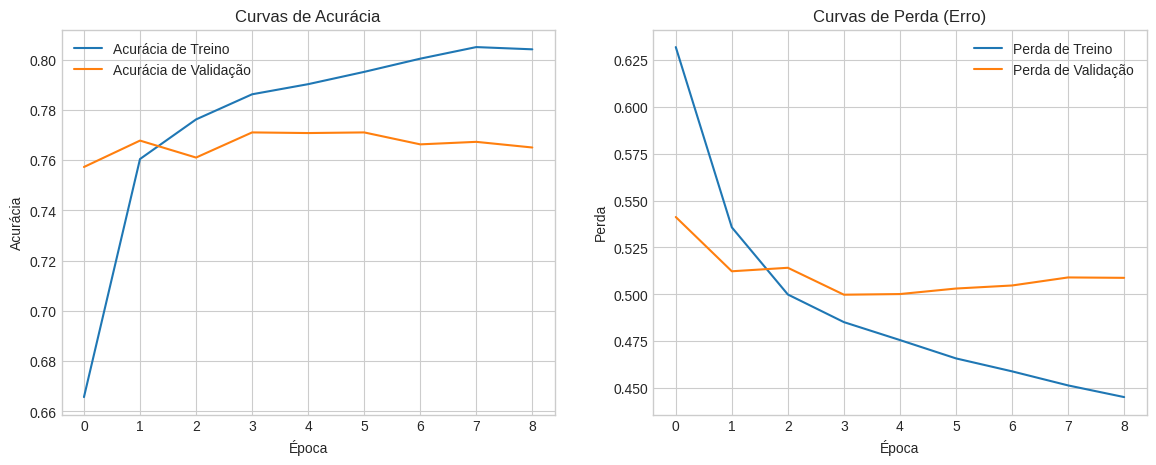

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history.history['accuracy'], label='Acurácia de Treino')
ax1.plot(history.history['val_accuracy'], label='Acurácia de Validação')
ax1.set_title('Curvas de Acurácia')
ax1.set_xlabel('Época')
ax1.set_ylabel('Acurácia')
ax1.legend()

ax2.plot(history.history['loss'], label='Perda de Treino')
ax2.plot(history.history['val_loss'], label='Perda de Validação')
ax2.set_title('Curvas de Perda (Erro)')
ax2.set_xlabel('Época')
ax2.set_ylabel('Perda')
ax2.legend();

## Examples

In [ ]:
predictions = model.predict(X_test_pad)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Selecionar 5 exemplos aleatórios para exibir
test_samples = X_test.sample(5, random_state=101)
sample_indices = test_samples.index

print("\n--- 5 Exemplos de Predição do Conjunto de Teste ---\n")

for i, index in enumerate(sample_indices):
    original_text = df.loc[index, 'text']
    true_label_val = y_test.loc[index]
    predicted_label_val = predicted_labels[X_test.index.get_loc(index)]

    print(f"Exemplo {i+1}:")
    print(f"  Tweet Original: {original_text}")
    print(f"  Rótulo Verdadeiro: {map_label(true_label_val)}")
    print(f"  Predição do Modelo: {map_label(predicted_label_val)}")
    print("-" * 20)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

--- 5 Exemplos de Predição do Conjunto de Teste ---

Exemplo 1:
  Tweet Original: Wow,strangely, I'm  calm. Thank God.  ok la, goodnight tweeteries  @simonpurwa hey,should play golf sometime yeah? 
  Rótulo Verdadeiro: Positivo
  Predição do Modelo: Positivo
--------------------
Exemplo 2:
  Tweet Original: @matthewkheafy write anything, cause all the albums are awesome haha 
  Rótulo Verdadeiro: Positivo
  Predição do Modelo: Positivo
--------------------
Exemplo 3:
  Tweet Original: @DavidRN107 I'm sorry  that sucks!
  Rótulo Verdadeiro: Negativo
  Predição do Modelo: Negativo
--------------------
Exemplo 4:
  Tweet Original: @hughsbeautiful Because it aired already  I can get BBC 1 and 2 on my television. And Hugh was brilliant! :p
  Rótulo Verdadeiro: Positivo
  Predição do Modelo: Positivo
--------------------
Exemplo 5:
  Tweet Original: @kamla I envy U! You're watching classics &amp; I'm getting ready 4 work. Do let me know about your th

# Using GloVe

## Preprocess Data

### Split Train, Val and Test Data

In [ ]:
X = df['cleaned_text']
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.iloc[0]

'how was i supposed to know she was a crack whore in her past it was still a funny joke her friendship will be missed '

### Download GloVE

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2025-08-30 15:24:57--  http://nlp.stanford.edu/data/glove.6B.zip
Resolvendo nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Conectando-se a nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... conectado.
A requisição HTTP foi enviada, aguardando resposta... 302 Found
Localização: https://nlp.stanford.edu/data/glove.6B.zip [redirecionando]
--2025-08-30 15:25:03--  https://nlp.stanford.edu/data/glove.6B.zip
Conectando-se a nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... conectado.
A requisição HTTP foi enviada, aguardando resposta... 301 Moved Permanently
Localização: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [redirecionando]
--2025-08-30 15:25:04--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolvendo downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Conectando-se a downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... conectado.
A requisição HTTP foi enviada, aguardando resposta... 200 OK
Tamanho:

In [ ]:
glove_path = "glove.6B.50d.txt"

In [ ]:
embeddings_index = {}

with open(glove_path, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = vector

print("Total de vetores GloVe carregados:", len(embeddings_index))

Total de vetores GloVe carregados: 400000


In [ ]:
vocab_size = len(tokenizer.word_index) + 1  # +1 para o índice 0 (padding)

embedding_matrix = np.zeros((vocab_size, MAX_LEN))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print("Formato da matriz de embeddings:", embedding_matrix.shape)

Formato da matriz de embeddings: (35244, 50)


## Train Data

### Model

In [ ]:
model= Sequential([
    Input(shape=(MAX_LEN,)),
    Embedding(
        input_dim=vocab_size,
        output_dim=50,
        weights=[embedding_matrix],
        trainable=True
    ),
    LSTM(8, return_sequences=False),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)        │ (None, 50, 50)         │     1,762,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 8)              │         1,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,764,097 (6.73 MB)

 Trainable params: 1,764,097 (6.73 MB)

 Non-trainable params: 0 (0.00 B)

### Train

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train_pad, y_train,
                    epochs=30,
                    batch_size=64,
                    validation_split=0.1, # Usa 10% dos dados de treino para validação
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.6935 - loss: 0.5794 - val_accuracy: 0.7560 - val_loss: 0.5096
Epoch 2/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.7782 - loss: 0.4750 - val_accuracy: 0.7745 - val_loss: 0.4789
Epoch 3/30
132/563 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.8019 - loss: 0.4413

KeyboardInterrupt: 

## Test

In [ ]:
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f'\nAcurácia no Conjunto de Teste: {accuracy * 100:.2f}%')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7688 - loss: 0.4907

Acurácia no Conjunto de Teste: 76.88%


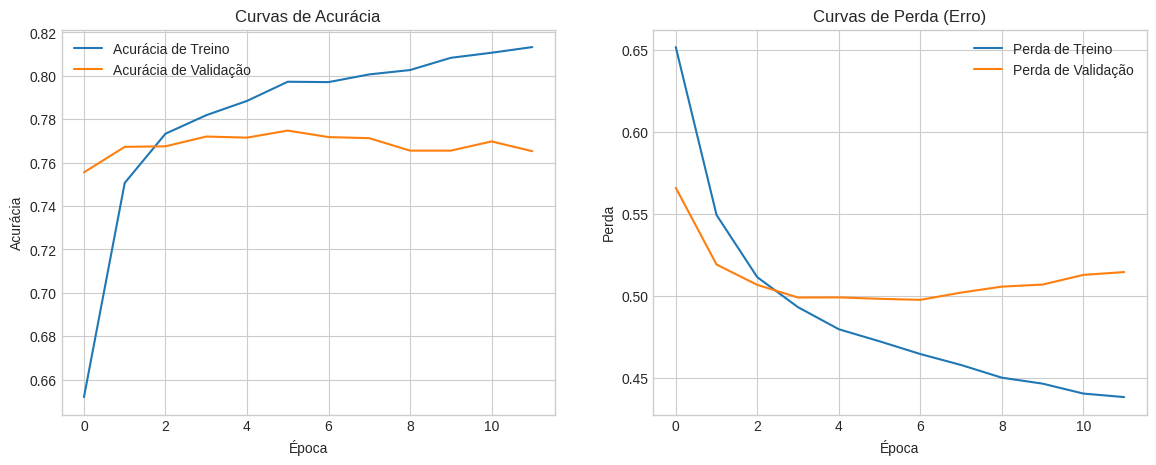

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history.history['accuracy'], label='Acurácia de Treino')
ax1.plot(history.history['val_accuracy'], label='Acurácia de Validação')
ax1.set_title('Curvas de Acurácia')
ax1.set_xlabel('Época')
ax1.set_ylabel('Acurácia')
ax1.legend()

ax2.plot(history.history['loss'], label='Perda de Treino')
ax2.plot(history.history['val_loss'], label='Perda de Validação')
ax2.set_title('Curvas de Perda (Erro)')
ax2.set_xlabel('Época')
ax2.set_ylabel('Perda')
ax2.legend();

## Examples

In [ ]:
predictions = model.predict(X_test_pad)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Selecionar 5 exemplos aleatórios para exibir
test_samples = X_test.sample(5, random_state=101)
sample_indices = test_samples.index

print("\n--- 5 Exemplos de Predição do Conjunto de Teste ---\n")

for i, index in enumerate(sample_indices):
    original_text = df.loc[index, 'text']
    true_label_val = y_test.loc[index]
    predicted_label_val = predicted_labels[X_test.index.get_loc(index)]

    print(f"Exemplo {i+1}:")
    print(f"  Tweet Original: {original_text}")
    print(f"  Rótulo Verdadeiro: {map_label(true_label_val)}")
    print(f"  Predição do Modelo: {map_label(predicted_label_val)}")
    print("-" * 20)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

--- 5 Exemplos de Predição do Conjunto de Teste ---

Exemplo 1:
  Tweet Original: Wow,strangely, I'm  calm. Thank God.  ok la, goodnight tweeteries  @simonpurwa hey,should play golf sometime yeah? 
  Rótulo Verdadeiro: Positivo
  Predição do Modelo: Positivo
--------------------
Exemplo 2:
  Tweet Original: @matthewkheafy write anything, cause all the albums are awesome haha 
  Rótulo Verdadeiro: Positivo
  Predição do Modelo: Positivo
--------------------
Exemplo 3:
  Tweet Original: @DavidRN107 I'm sorry  that sucks!
  Rótulo Verdadeiro: Negativo
  Predição do Modelo: Negativo
--------------------
Exemplo 4:
  Tweet Original: @hughsbeautiful Because it aired already  I can get BBC 1 and 2 on my television. And Hugh was brilliant! :p
  Rótulo Verdadeiro: Positivo
  Predição do Modelo: Positivo
--------------------
Exemplo 5:
  Tweet Original: @kamla I envy U! You're watching classics &amp; I'm getting ready 4 work. Do let me know about your th